In [ ]:
from providedHelpers import *
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
tones = ['b', 's', 'j', 'v', 'm', 'g', 'd', '0']

import re
from collections import deque

To start, we'd like to save as .np files the word embeddings for all the words in the data.

To get all the words, we'll load in the data in the same way we did for the word type exploration

In [ ]:
words = set()
for tone in tones:
    file = f'./normalized_AVG/hmongData-{tone}-ST_AVG.csv'
    df = pd.read_csv(file)

    for index, row in df.iterrows():
        raw_word = row.loc['Word']
        if '_' in raw_word:
            word = raw_word.split('_')[0]
        else: word = raw_word
        if word == '': continue # long story, don't worry
        words.add(word)

In [67]:
def construct_word_embedding(word: str):
    embedding = embed_text(word)
    np.save(f'./word_embeddings/{word}.npy', embedding)
    return embedding

In [1]:
def read_word_embedding(word: str):
    return np.load(f'./word_embeddings/{word}.npy')

In [72]:
# We're gonna define a new class, which holds on to a couple of things:
# Target word, context window, tone. TOKEN ID (by-tone, matching our database) 
# Has the functionality to get the context embedding, and then average that with the word embedding to get our final embedding
# Also has the functionality to save that to file in ./context_embeddings/{tone}/{id}.npy

class ContextWindow:
    def __init__(self, word: str, context_window: list[str], tone: str, token_id: int):
        self.word = word
        self.context_window = ' '.join(context_window)
        self.tone = tone
        self.token_id = token_id

    def __eq__(self, other):
        return (self.context_window == other.context_window)
        
    def __hash__(self):
        return hash(self.context_window)


In [ ]:
# Because speakers did not exactly follow the text, instead of using the story text, we'll be using the words themselves
#  Let's actually redefine textProcess to give us "sentences". 
# Later on, we'll use fun code to make sure that we aren't doing multiple of the same encoding for no reason

import tgt

def textProcessCEs(file: str) -> list:
    raw_grid = tgt.read_textgrid(f"./textgrid/{file}.TextGrid") # tgt TextGrid object

    sentences = []
    current = []
    for interval in raw_grid.tiers[0]:
        current_text = interval.text
        current_text_list = current_text.split('_')

        if 'ui' in current_text_list and len(current) > 0:
            # we want this to handle cases where an utterance starts without technically ending (we never saw the uf)
            # essentially just do everything that would occur below, but do it here!
            sentences.append(current)
            current = []

        current.append(current_text_list[0])

        if 'uf' in current_text_list:
            sentences.append(current)
            current = []
    
    sentences.append(current)
    current = []

    return sentences
        

In [77]:
speakers = ['Cha', 'Chingla', 'Ellina', 'Gozong', 'Long', 'MaiXee', 'MaiXor', 'Ma']
stories = ['1', '2', '3']

all_sentences = []
for speaker in speakers:
    for story in stories:
        file = f'{speaker}Story{story}'
        for sentence in textProcessCEs(file):
            all_sentences.append(sentence)

In [79]:
# Now we'll use those "sentences" and create all of these context windows. Ideally the correct number this time

windows_to_embed = []

window_length = 3
tone_id_counter = {'b': 0, 's': 0, 'j': 0, 'v': 0, 'm': 0, 'g': 0, 'd': 0, '0': 0}
for sentence in all_sentences:
    if len(sentence) < 1: continue

    if sentence[0] == '': 
        if len(sentence) > 1: 
            sentence = sentence[1:]
        else: pass

    # set up context deque
    context_deque = deque()
    for i in range(min(window_length + 1, len(sentence))):
        context_deque.append(sentence[i])

    for i, word in enumerate(sentence):
        # get the tone
        current_tone = word[-1:]
        if current_tone not in tones:
            current_tone = '0'

        window = ContextWindow(word, list(context_deque), current_tone, tone_id_counter[current_tone])
        windows_to_embed.append(window)
        if current_tone == 'v':
            # print(window.word, window.tone, window.token_id, window.context_window)
            pass

        # increment tone counter
        tone_id_counter[current_tone] += 1

        # manage context deque:
        if i + 1 + window_length < len(sentence):
            context_deque.append(sentence[i + 1 + window_length])
        else:
            # if we drop into this case, we've reached the end of the sentence, so we need to just keep popping left to the end
            context_deque.popleft()
        if len(context_deque) > (2 * window_length) + 1:
            context_deque.popleft()

    # finish up
    while len(context_deque) >= window_length + 1:
        # get the tone
        current_tone = word[-1:]
        if current_tone not in tones:
            current_tone = '0'

        window = ContextWindow(word, list(context_deque), current_tone, tone_id_counter[current_tone])
        windows_to_embed.append(window)
        if current_tone == 'v':
            # print(window.word, window.tone, window.token_id, window.context_window)
            pass

        # increment tone counter
        tone_id_counter[current_tone] += 1

        # manage context deque:
        if i + 1 + window_length < len(sentence):
            context_deque.append(sentence[i + 1 + window_length])
        context_deque.popleft()

In [80]:
print(len(windows_to_embed))
# actual_windows = set()

print(len(set(windows_to_embed)))

11283
4065


Here's the thing- `windows_to_embed` is incredible, and there's a world where all we need to do is:
1. Create the set form of windows_to_embed, to make sure we aren't wasting API calls
2. Encode all of the windows in that set
3. Iterate over windows_to_embed in such a way that it saves all of our necessary embeddings. kind of easy!

However... we can't just use the utterances without being smart about it. Mostly because of the very short utterances.

In [81]:
set_windows = set(windows_to_embed)
len_1 = 0
len_2 = 0
len_3 = 0
for window in set_windows:
    if len(window.context_window.split(' ')) == 1:
        len_1 += 1
    if len(window.context_window.split(' ')) == 2:
        len_2 += 1
    if len(window.context_window.split(' ')) == 3:
        len_3 += 1


print(len_1)
print(len_2)
print(len_3)

# You know what, that's not that many... I might just let it rock with this solution. Maybe I'll hold off until wednesday so I can chat with zuoyu first though
# Let's get all the data, maybe we could even do a viz!

159
383
415


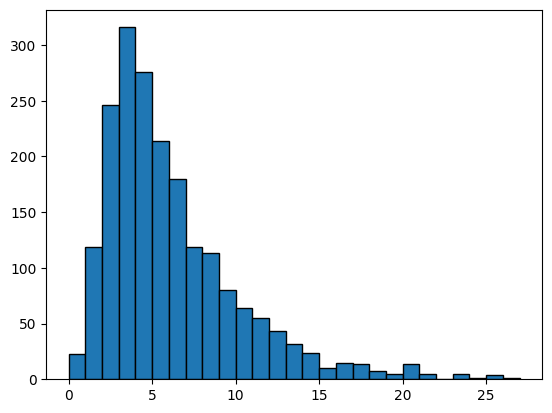

In [82]:

import matplotlib.pyplot as plt

phrase_lengths = []
for phrase in all_sentences:
    phrase_lengths.append(len(phrase))



# Create the boxplot
plt.hist(phrase_lengths, bins=range(min(phrase_lengths), max(phrase_lengths) + 1, 1), edgecolor='black')

# Display the plot
plt.show()

Following Chuang et. al, we'd love to have access to the current AND previous utterance as we create these context windows
Given this distribution of phrase lengths, I think we're justified in doing so.
We'll start with the logic for that, then try to make a better context window solution, then ideally finally do the stuff!

In [83]:
# Just really quick we need to create all_sentences in a slightly different way! Sorry!

speakers = ['Cha', 'Chingla', 'Ellina', 'Gozong', 'Long', 'MaiXee', 'MaiXor', 'Ma']
stories = ['1', '2', '3']

phrases_by_story = []
for speaker in speakers:
    for story in stories:
        phrases_by_story.append(textProcessCEs(f'{speaker}Story{story}'))

In [ ]:
# sanity check
print(phrases_by_story[0][0])

['puag', 'thaum', 'ub']


In [85]:
# We'll modify all_sentences to create a list of (list, int) tuples! 
# The list is the phrase WITH the previous phrase added on the beginning, and the index is what word we should treat as the beginning of the phrase
# I.e. len(prev_phrase)

all_phrases = []
for story in phrases_by_story:

    # We don't want utterances leaking between stories!
    prev_phrase = None
    # print(story[0])

    for phrase in story:
        # beginning of a story
        if prev_phrase is None:
            all_phrases.append((phrase, 0))
            prev_phrase = phrase
            continue

        new_phrase = []
        for w in prev_phrase: new_phrase.append(w)
        for w in phrase: new_phrase.append(w)
        all_phrases.append((new_phrase, len(prev_phrase)))

        prev_phrase = phrase
# all_phrases


In [86]:
# Now we can create our real list of ContextWindow objects!
window_length = 3
tone_id_counter = {'b': 0, 's': 0, 'j': 0, 'v': 0, 'm': 0, 'g': 0, 'd': 0, '0': 0}
windows_to_embed_real = []
for phrase, lower_bound in all_phrases:
    for i, word in enumerate(phrase):
        if i < lower_bound: continue
        current_tone = word[-1:]
        if current_tone not in tones: current_tone = '0'
        left_index = max(lower_bound, i - window_length)
        right_index = min(len(phrase), i + window_length + 1)
        context_window = phrase[left_index:right_index]
        windows_to_embed_real.append(ContextWindow(word, context_window, current_tone, tone_id_counter[current_tone]))
        tone_id_counter[current_tone] += 1

In [87]:
v_windows = []
for window in windows_to_embed_real:
    if window.tone == 'v':
        v_windows.append(window)

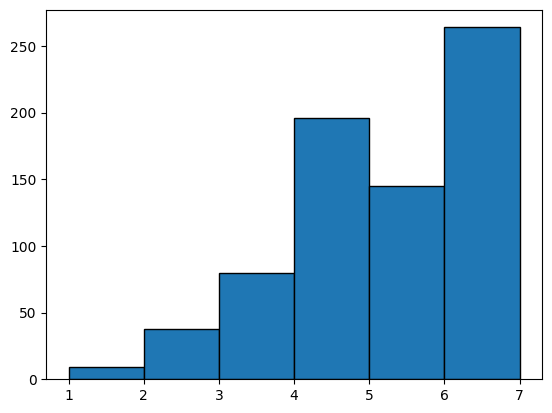

In [88]:
import matplotlib.pyplot as plt

set_windows = set(v_windows)

window_lengths = []
for window in set_windows:
    window_lengths.append(len(window.context_window.split(' ')))


# Create the boxplot
plt.hist(window_lengths, bins=range(min(window_lengths), max(window_lengths) + 1, 1), edgecolor='black')

# Display the plot
plt.show()

In [ ]:
# sanity check
for w in set_windows:
    assert hash(w) == hash(w.context_window)

In [ ]:
# API CALL! THE BIG ONE!!!
for window in v_windows:
    word_embed = np.load(f'word_embeddings/{window.word}.npy')
    try:
        # this case occurs when we've already embedded the context
        context_embed = np.load(f'hashed_contexts/{hash(window)}.npy')
    except Exception:
        # this case works for when we need to embed the context
        print('Embedding context:', window.context_window)
        try:
            context_embed = embed_text(window.context_window)
        except Exception:
            # this case occurs when something out of our control goes wrong-- we just re-run the code again
            print(f'Failed for {window.context_window}, breaking out!')
            break
        np.save(f'hashed_contexts/{hash(window)}', context_embed)
    final_context_embedding = word_embed + context_embed
    np.save(f'v_context_embeddings/{window.token_id}.npy', final_context_embedding)

Embedding context: ceev heev kom tsov sab sab
Embedding context: khia tsis taus ntxiv
Embedding context: tsis ceev npaum tsov los nws lub
Embedding context: thiaj tsis muaj mov noj thiaj tsis
Embedding context: ntsuag tshaib plab heev nws thiaj li
Embedding context: kub zoo nkauj heev ua rau nws
Embedding context: rau nws tsis xav no
Embedding context: muab tso rau hauv ib lub hub
Embedding context: siab heev rau cov zaub mov tiam
Embedding context: tiag nws mus khiav nkaum nraum zoov
Embedding context: khiav nkaum nraum zoov xwb
Embedding context: niam siab phem heev hu ua niam
Embedding context: niam zoo nkauj heev li ces nws
Embedding context: kaws tub nkeeg heev nws tsis ua
Embedding context: nws tsis ua mov noj thiab tsis
Embedding context: hnub ib tug qav pom ntsuag nws
Embedding context: paj no ces kuv mam nqus cov
Embedding context: kuv mam nqus cov dej kom
Embedding context: txhob luag li nawv
Embedding context: txawm teb tias kuv twb hais kom
Embedding context: qav rov qab nq